In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pytz
import re
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
# Load data from CSV
df = pd.read_csv('Data/tweet_dump.csv',
    parse_dates=['tweet_created'],
    usecols=['tweet_created', 'tweet_data'],
    index_col=0)

df.index = df.index.tz_convert('America/Toronto')

df

,tweet_data
tweet_created,
2022-09-19 22:36:58-04:00,WR 172\nCM 30\nSPIN 18
2022-09-19 22:00:14-04:00,WR 207🦾\nCM 53🏃\nSpin 12🌀
2022-09-19 21:32:02-04:00,WR 210 😎\nCM 49\nSPIN 11
2022-09-19 21:11:52-04:00,WR 221\nCM 45\nSPIN 15
2022-09-19 20:53:34-04:00,WR 183 \nCM 36\nSPIN 24
...,...
2020-02-18 13:33:14-05:00,WR 44 CM 13
2020-02-18 12:29:44-05:00,WR 35 CM 13
2020-02-18 11:57:11-05:00,WR 30 CM 15


In [3]:
# Filter out data from before 2022
startDate = datetime(2022, 1, 1, 0, 0, 0, tzinfo=pytz.timezone('America/Toronto'))
mask = (df.index > startDate)
df = df.loc[mask]

# Convert to human-readable string
plotStartDate = df.index.min().strftime('%Y-%b-%d')
plotEndDate = df.index.max().strftime('%Y-%b-%d')

In [4]:
# Extract occupancy from tweet_data column by capturing first occurrence of a number in the tweet
def extractNums(row):
    matches = re.findall(r'[a-zA-Z]+[^\d]*\d+', row['tweet_data'])
    nWR = None
    nCM = None
    nSPIN = None
    for s in matches:
        if 'WR' in s.upper():
            nWR = int(re.findall(r'\d+', s)[0])
        elif 'CM' in s.upper():
            nCM = int(re.findall(r'\d+', s)[0])
        elif 'SPIN' in s.upper():
            nSPIN = int(re.findall(r'\d+', s)[0])
    return nWR, nCM, nSPIN

# Merge results into dataframe by concatenating along the columns
dfOcc = pd.DataFrame(df.apply(extractNums, axis=1).tolist(),
    index=df.index,
    columns=['WR', 'CM', 'SPIN']
)

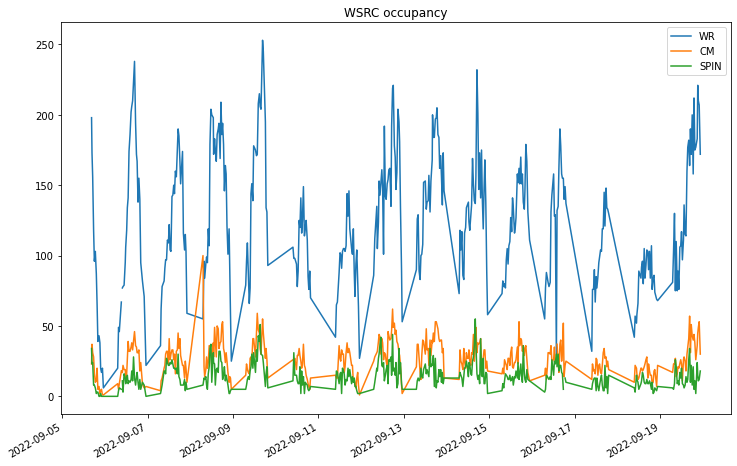

In [5]:
# Plot raw occupancy data
ax = dfOcc.plot(
    title='WSRC occupancy',
    xlabel='',
    figsize=(12, 8)
)

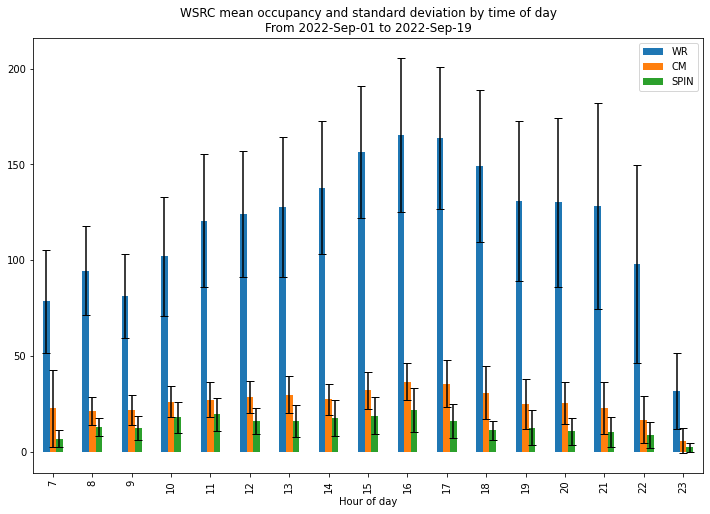

In [6]:
# Plot occupancy by time of day
groupHour = dfOcc.groupby(df.index.hour)

ax = groupHour.mean().plot.bar(
    yerr=groupHour.std(),
    title='WSRC mean occupancy and standard deviation by time of day\nFrom '+plotStartDate+' to '+plotEndDate,
    xlabel='Hour of day',
    capsize=4,
    figsize=(12, 8)
)

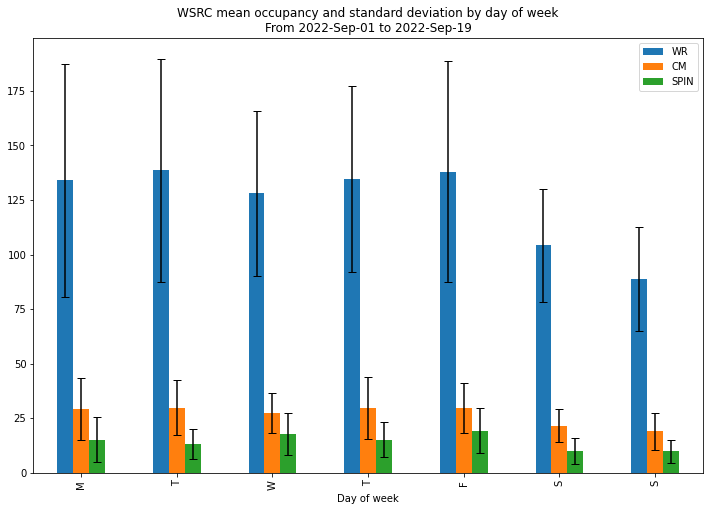

In [7]:
# Plot occupancy by day of the week
groupWkday = dfOcc.groupby(df.index.weekday)

days = ['M', 'T', 'W', 'T', 'F', 'S', 'S']

means = groupWkday.agg(np.mean)
means.index = days

errors = groupWkday.agg(np.std)
errors.index = days

ax = means.plot.bar(
   yerr=errors,
   title='WSRC mean occupancy and standard deviation by day of week\nFrom '+plotStartDate+' to '+plotEndDate,
   xlabel='Day of week',
   capsize=4,
   figsize=(12, 8)
)